<a href="https://colab.research.google.com/github/aelienmoubeche/reinforcement-learning-snn/blob/main/examples/STDP_report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ANNarchy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from ANNarchy import *

ANNarchy 4.7 (4.7.2) on linux (posix).


In [3]:
import matplotlib.pyplot as plt

#Leaky-Integrate-and-Fire Neuron Simulation

In [4]:
# Parameters
dt = 0.1
setup(dt=dt)
gmax = 0.5 # Maximum weight

# Parameters for the noise inputs
F = 10
N = 3


In [5]:
# Leaky-integrate-and-fire neuron class declaration
# Parameters are tau, the time constant for the neuron, B, the baseline activity potential, T, the threshold potential at which the neuron spikes and R, the conductance of the neuron
# mu and sigma are used to simulate extrinsic inputs and are modelised by a gaussian distribution with said parameters (optionally removed)
# Equations are the leaky integrate and fire potential ODE as decribed by (Belkaid, 2020) with g_exc representing the input currents received, and either an instantaneous reset or exponentially decaying synapses
# Spike condition and potential reset equation are also specified
# Since the simulation time step (dt) is set at 0.01, a refractory time of 0.5 will means 50 steps of ignoring the inputs received by the membrane

LIF = Neuron(
    parameters='''
        tau = 20.0 : population
        tau_exc = 5.0
        B = -2.0
        T = 1.0 : population
        mu = 0.15 : population
        sigma = 0.05 : population
        R = 20.0 : population
    ''', 
    equations='''
        tau * dv/dt = -v + B + (g_exc) * R
        tau_exc * dg_exc/dt = - g_exc
    ''',
    spike='''
        v >= T
    ''',
    reset='''
        v = B
    ''',
    refractory = 0.5
)


#STDP synapse [Source code](https://github.com/ANNarchy/ANNarchy/blob/master/ANNarchy/models/Synapses.py)

In [6]:
# Asymmetrical : tau_minus = 5 * tau_plus


STDP = Synapse(
        parameters = """
            tau_plus = 20.0 : projection
            tau_minus = 100.0 : projection
            A_plus = 0.01 : projection
            A_minus = 0.01 : projection
            w_min = 0.0 : projection
            w_max = 1.0 : projection
        """,
        equations = """
            tau_plus  * dx/dt = -x : event-driven
            tau_minus * dy/dt = -y : event-driven
        """,
        pre_spike="""
            g_target += w
            x += A_plus * w_max
            w = clip(w + y, w_min , w_max)
        """,
        post_spike="""
            y -= A_minus * w_max
            w = clip(w + x, w_min , w_max)
        """
    )

###Populations declaration and projection

In [7]:
# 1 LIF neuron, initialised at its rest potential B = -2.0
postsynaptic = Population(name = 'LIF', neuron=LIF, geometry=1)
postsynaptic.v = -2


# Spikes defined by the timing of their arrival are used as inputs
presynaptic = SpikeSourceArray(spike_times=[53, 63, 73, 83, 93, 200, 210, 220, 230, 240, 249, 260, 270, 426, 436, 446, 456, 466, 476, 486, 496, 800, 810, 820, 830, 840, 850, 860, 870])

#noise = PoissonPopulation(name = 'InputNoise', geometry=N, rates=F)
noise = SpikeSourceArray(spike_times=[43, 250, 486, 750, 835, 845, 855])




In [8]:
proj = Projection(
    pre = presynaptic,
    post = postsynaptic,
    target = 'exc',
    synapse = STDP
)

proj2 = Projection(
    pre = noise,
    post = postsynaptic,
    target = 'exc'
)

In [9]:

# default weight chosen for simulation purposes, the default synapse sends raises the conductance at each step and adds its weight to the g_exc "inputs" received by the postsynaptic neuron
proj.connect_all_to_all(weights=0.01)
proj2.connect_all_to_all(weights=1)




In [10]:
compile()

In [11]:
# Start recording

dendrite = proj[0]

M_input = Monitor(presynaptic, 'spike')
M_noise = Monitor(noise, 'spike')
M_output = Monitor(postsynaptic, ['spike', 'v', 'g_exc'])
M_weight = Monitor(dendrite, 'w')

# Simulation of 1s
simulate(1000.0, measure_time=True)

Simulating 1.0 seconds of the network took 0.0034885406494140625 seconds. 


In [12]:
input_spikes = M_input.get('spike')
noise_spikes = M_noise.get('spike')
output_spikes = M_output.get('spike')
output_v = M_output.get('v')
output_g_exc = M_output.get('g_exc')
weight = M_weight.get('w')

input_histogram = M_input.histogram(input_spikes)
noise_histogram = M_noise.histogram(noise_spikes)
output_histogram = M_output.histogram(output_spikes)

In [13]:
print(weight)

[0.01 0.01 0.01 ... 0.   0.   0.  ]


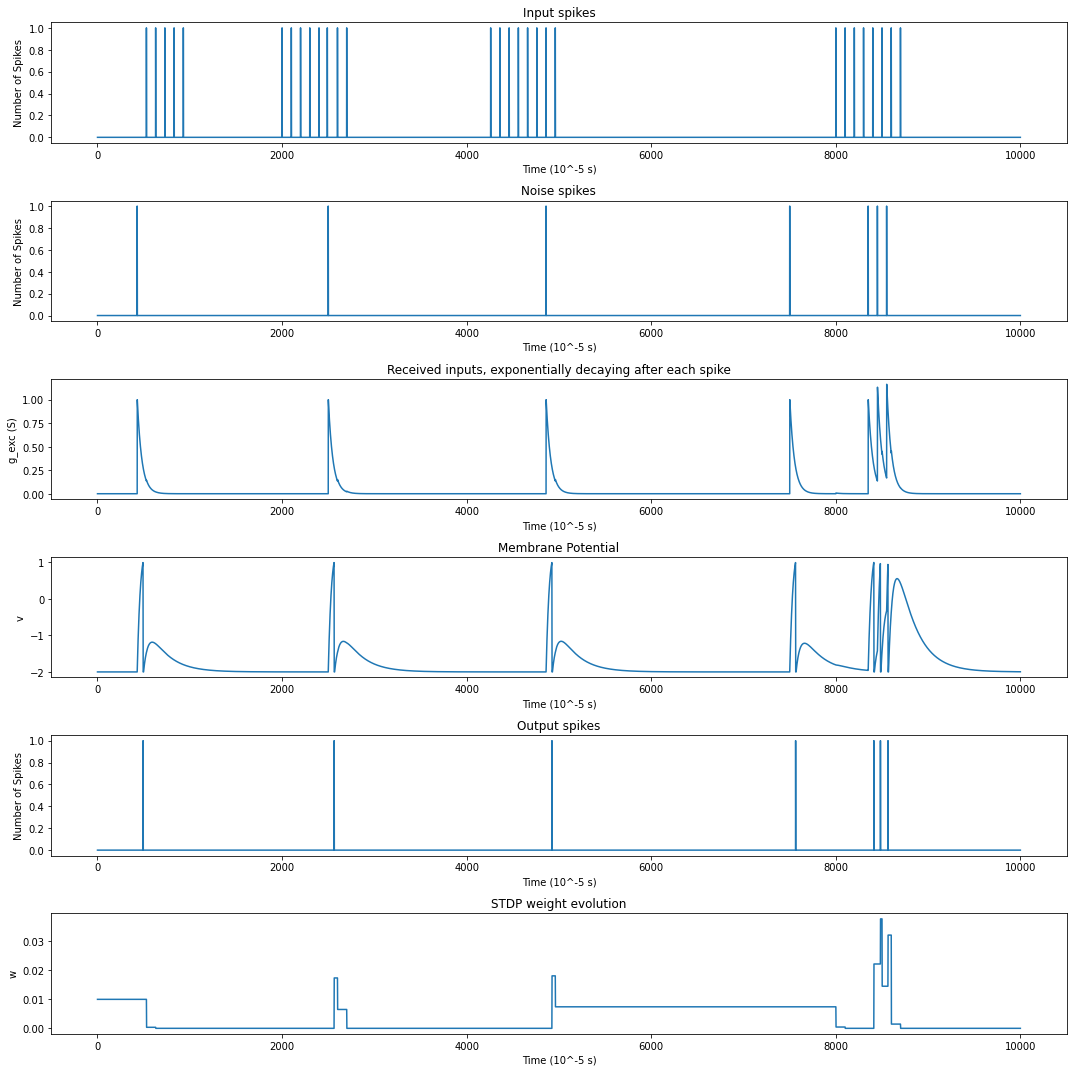

In [14]:
plt.figure(figsize=(15,15))




plt.subplot(611)
plt.plot(input_histogram)
plt.title('Input spikes')
plt.xlabel('Time (10^-5 s)')
plt.ylabel('Number of Spikes')

plt.subplot(612)
plt.plot(noise_histogram)
plt.title('Noise spikes')
plt.xlabel('Time (10^-5 s)')
plt.ylabel('Number of Spikes')

plt.subplot(613)
plt.title('Received inputs, exponentially decaying after each spike')
plt.plot(output_g_exc)
plt.xlabel('Time (10^-5 s)')
plt.ylabel('g_exc (S)')

plt.subplot(614)
plt.title('Membrane Potential')
plt.plot(output_v)
plt.xlabel('Time (10^-5 s)')
plt.ylabel('v')

plt.subplot(615)
plt.plot(output_histogram)
plt.title('Output spikes')
plt.xlabel('Time (10^-5 s)')
plt.ylabel('Number of Spikes')

plt.subplot(616)
plt.plot(weight)
plt.title('STDP weight evolution')
plt.xlabel('Time (10^-5 s)')
plt.ylabel('w')

plt.tight_layout()
plt.show()


In [15]:
import json

In [16]:
noise_json = json.dumps(noise_spikes)

In [17]:
with open("noise.json", "w") as outfile:
    outfile.write(noise_json)

In [18]:
np.save('weights.npy', weight)